In [171]:
import numpy as np
import os
import pandas as pd
from itertools import product
from pulp import LpProblem, LpVariable, lpSum, lpDot, value, const
import networkx as nx

os.chdir(os.path.dirname(os.path.abspath(__file__)))

In [172]:
# 1.データ読み込み
# 1-1.各倉庫から工場への輸送コストデータ
trans_cost = pd.read_csv("input/trans_cost.csv", index_col="工場")
trans_cost.head()

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [173]:
# 1-2.各工場の必要最低生産数データ
min_factory_demand = pd.read_csv("input/demand.csv")
min_factory_demand

,F1,F2,F3,F4
0,28,29,31,25


In [174]:
# 1-3.各倉庫の最大供給可能部品数データ
max_warehouse_supply = pd.read_csv("input/supply.csv")
max_warehouse_supply

,W1,W2,W3
0,35,41,42


In [175]:
# 2.初期設定
np.random.seed(1)
# 各倉庫と各工場のデカルト積（itertools.product型）のリストを作成
pr = list(
    product(
        range(len(max_warehouse_supply.columns)), range(len(min_factory_demand.columns))
    )
)
pr

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3)]

In [176]:
# 3.数理モデル作成
# LP problemクラスのオブジェクトを作成(最小化問題として定義する)
prob = LpProblem(sense=const.LpMinimize)

# 変数(各ルートの輸送量)をprをキーとしたディクショナリ型で定義
# 最小値は0,整数型に制約する
v1 = {(i, j): LpVariable(f"v{i}_{j}", lowBound=0, cat=const.LpInteger) for i, j in pr}

# 目的関数の定義(各ルートの輸送コストと各ルートの輸送量の積の総和)
prob += lpSum(trans_cost.iloc[i, j] * v1[i, j] for i, j in pr)

# 「制約条件1：各倉庫の部品供給数が最大部品供給数を超えない」を追加
for i in range(len(max_warehouse_supply.columns)):
    prob += (
        lpSum(v1[i, j] for j in range(len(min_factory_demand.columns)))
        <= max_warehouse_supply.iloc[0, i]
    )

# 「制約条件2:各工場が最低生産数以上を生産」を追加
for j in range(len(min_factory_demand.columns)):
    prob += (
        lpSum(v1[i, j] for i in range(len(max_warehouse_supply.columns)))
        >= min_factory_demand.iloc[0, j]
    )

# 最小化問題を解く
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x1/__2lmnqj06b4qgghn00dv0s40000gn/T/8b30f882a838483bb780c7018e57fb1a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/x1/__2lmnqj06b4qgghn00dv0s40000gn/T/8b30f882a838483bb780c7018e57fb1a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 73 RHS
At line 81 BOUNDS
At line 94 ENDATA
Problem MODEL has 7 rows, 12 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1296 - 0.00 seconds
Cgl0004I processed model has 7 rows, 12 columns (12 integer (0 of which binary)) and 24 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 1296 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - be

1

In [177]:
# 4.総輸送コスト計算
# 各ルートの輸送量の最適解を代入するデータフレームを作成
data = np.zeros(
    (len(max_warehouse_supply.columns), len(min_factory_demand.columns)), dtype=int
)
trans_route_solved = pd.DataFrame(
    data, columns=min_factory_demand.columns, index=max_warehouse_supply.columns
)

# 総輸送量コストの変数を定義（初期値0）
total_cost = 0

# 変数v1（最適解に更新されている）は辞書型。キーをk, 値をxに代入する
for k, x in v1.items():
    i, j = k[0], k[1]
    # 先に作成したデータフレームの各要素に対応するルートの輸送量の最適解を代入
    trans_route_solved.iloc[i, j] = value(x)
    # 総輸送量コストにそのルートの輸送コストを加算
    total_cost += trans_cost.iloc[i, j] * value(x)

print(trans_route_solved)
print(f"最適化ルートの総輸送コスト:{total_cost}")

    F1  F2  F3  F4
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
最適化ルートの総輸送コスト:1296.0


In [178]:
# ノード座標の読み込み
trans_route_pos = pd.read_csv("input/trans_route_pos.csv")
trans_route_pos.head()

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


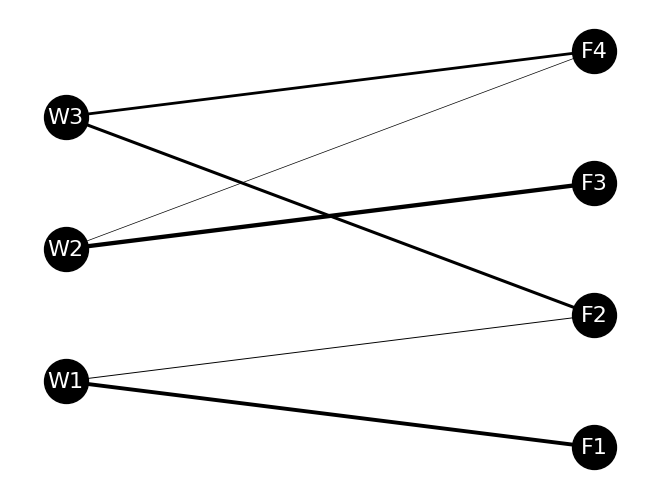

In [179]:
# グラフオブジェクトの作成
G = nx.Graph()

# ノードの設定
for i in range(len(trans_route_pos.columns)):
    G.add_node(trans_route_pos.columns[i])

# エッジの設定とエッジの重みのリスト化
edge_weights = []
size = 0.1

for i in range(len(trans_route_solved.index)):
    for j in range(len(trans_route_solved.columns)):
        # エッジの追加
        G.add_edge(trans_route_solved.columns[j], trans_route_solved.index[i])

        # エッジの重みのリスト化
        weight = (
            trans_route_solved.loc[
                trans_route_solved.index[i], trans_route_solved.columns[j]
            ]
            * size
        )
        edge_weights.append(weight)

# ノードの座標の設定
pos = {}
for i in range(len(trans_route_pos.columns)):
    node = trans_route_pos.columns[i]
    pos[node] = (trans_route_pos.loc[0, node], trans_route_pos.loc[1, node])

# 描画
nx.draw(
    G,
    pos,
    with_labels=True,
    font_size=16,
    node_size=1000,
    node_color="k",
    font_color="w",
    width=edge_weights,
)

In [180]:
# 制約条件を満たしているかを確認する
# 1.制約条件を確認する関数の作成
# 1-1.各工場の最小生産数を達成できるかを確認する関数の作成
def min_factory_demand_condition(trans_route, min_factory_demand):
    flag = np.zeros(len(min_factory_demand.columns))

    for i in range(len(min_factory_demand.columns)):
        min_demand = min_factory_demand.loc[0, min_factory_demand.columns[i]]
        temp_sum = sum(trans_route.loc[:, min_factory_demand.columns[i]])

        # 工場の最小生産数を達成できていればフラグを立てる
        if temp_sum >= min_demand:
            flag[i] = 1
    return flag


# 1-2.各倉庫の供給可能部品数以下に抑えられているかを確認する関数の作成
def max_warehouse_supply_condition(trans_route, max_warehouse_supply):
    flag = np.zeros(len(max_warehouse_supply.columns))

    for i in range(len(max_warehouse_supply.columns)):
        max_supply = max_warehouse_supply.loc[0, max_warehouse_supply.columns[i]]
        temp_sum = sum(trans_route.loc[max_warehouse_supply.columns[i], :])

        # 倉庫の供給可能部品数以下に抑えられていればフラグを立てる
        if temp_sum <= max_supply:
            flag[i] = 1
    return flag

In [181]:
# 2.制約条件を満たしているかを確認する
print(
    f"各工場の最小生産数の達成確認結果(達成:1, 未達成:0): {min_factory_demand_condition(trans_route_solved,min_factory_demand)}"
)
print(
    f"各倉庫の供給可能部品数以下の達成確認結果(達成:1, 未達成:0): {max_warehouse_supply_condition(trans_route_solved,max_warehouse_supply)}"
)

各工場の最小生産数の達成確認結果(達成:1, 未達成:0): [1. 1. 1. 1.]
各倉庫の供給可能部品数以下の達成確認結果(達成:1, 未達成:0): [1. 1. 1.]


In [182]:
# 生産計画に関するデータを読み込む

In [183]:
# 1.製品の製造に必要な原料の割合
material = pd.read_csv("input/product_plan_material.csv", index_col="製品")
material

,原料1,原料2,原料3
製品,,,
製品1,1,4,3
製品2,2,4,1


In [184]:
# 2.製品の利益
profit = pd.read_csv("input/product_plan_profit.csv", index_col="製品")
profit

,利益
製品,
製品1,5.0
製品2,4.0


In [185]:
# 3.原料の在庫
stock = pd.read_csv("input/product_plan_stock.csv", index_col="項目")
stock

,原料1,原料2,原料3
項目,,,
在庫,40,80,50


In [186]:
# 4.製品の生産量
product_plan = pd.read_csv("input/product_plan.csv", index_col="製品")
product_plan

,生産量
製品,
製品1,16
製品2,0


In [187]:
# 利益を計算する関数を作成する
def calc_profit(profit, product_plan):
    total_profit = 0
    for i in range(len(product_plan.index)):
        total_profit += profit.iloc[i, 0] * product_plan.iloc[i, 0]
    return total_profit


print(f"総利益:{calc_profit(profit, product_plan)}")

総利益:80.0


In [188]:
# 生産最適化問題を解く

In [189]:
# LP problemクラスのオブジェクトを作成（最大化問題として定義する）
prob = LpProblem(sense=const.LpMaximize)

# 変数（各製品の生産量）を製品名をキーとしたディクショナリ型で定義
v1 = {
    (i): LpVariable(f"v{i}", lowBound=0, cat=const.LpInteger)
    for i in range(len(product_plan.index))
}

# 目的関数（総利益）の定義
prob += lpSum(profit.iloc[i, 0] * v1[i] for i in range(len(product_plan.index)))

# 制約条件（原料の利用量を在庫以下にする）を追加
for j in range(len(material.columns)):
    prob += (
        lpSum(material.iloc[i, j] * v1[i] for i in range(len(product_plan.index)))
        <= stock.iloc[0, j]
    )

# 最大化問題を解く
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x1/__2lmnqj06b4qgghn00dv0s40000gn/T/4d1bbdaa5ee24b7bb2d703e9fb3881b3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/x1/__2lmnqj06b4qgghn00dv0s40000gn/T/4d1bbdaa5ee24b7bb2d703e9fb3881b3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 21 RHS
At line 25 BOUNDS
At line 28 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 95 - 0.00 seconds
Cgl0004I processed model has 3 rows, 2 columns (2 integer (0 of which binary)) and 6 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of -95 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best ob

1

In [190]:
# 最適解（各製品の生産量）生産時の総利益を計算
product_plan_solved = product_plan.copy()

for k, x in v1.items():
    i = k
    product_plan_solved.iloc[i, 0] = value(x)

print(product_plan_solved)
print(f"最適生産時の総利益:{value(prob.objective)}")

      生産量
製品       
製品1    15
製品2     5
最適生産時の総利益:95.0


In [191]:
# 制約条件を満たしているか（各原料の使用量）を確認する
def stock_condition_check(product_plan, material, stock):
    flag = np.zeros(len(material.columns))
    for i in range(len(material.columns)):
        temp_sum = 0
        for j in range(len(product_plan.index)):
            temp_sum = temp_sum + material.iloc[j, i] * product_plan.iloc[j, 0]
        if temp_sum <= stock.iloc[0, i]:
            flag[i] = 1
        print(f"{material.columns[i]} 使用量:{temp_sum}, 在庫:{stock.iloc[0,i]}")
    return flag


print(f"制約条件計算結果:{stock_condition_check(product_plan_solved, material, stock)}")

原料1 使用量:25, 在庫:40
原料2 使用量:80, 在庫:80
原料3 使用量:50, 在庫:50
制約条件計算結果:[1. 1. 1.]


In [192]:
# ロジスティックネットワーク設計問題を解く（輸送ルートと生産計画の最適化を同時に考える）
# 前提：商品の需要は一定
# 「輸送コストと製造コストの和の最小化問題」を解く
# 制約条件：各店舗への製品の輸送量が需要を上回る

In [193]:
# 1.データ作成
products = list("AB")
shops = list("PQ")
factories = list("XY")
lanes = (2, 2)

In [194]:
# 1-1.輸送費テーブル(tb_trans_cost)
tb_trans_cost = pd.DataFrame(
    ((j, k) for j in shops for k in factories), columns=["商店", "工場"]
)
tb_trans_cost["輸送費"] = [1, 2, 3, 1]
tb_trans_cost

,商店,工場,輸送費
0,P,X,1
1,P,Y,2
2,Q,X,3
3,Q,Y,1


In [195]:
# 1-2.需要テーブル(tb_shop_demand)
tb_shop_demand = pd.DataFrame(
    ((j, i) for j in shops for i in products), columns=["商店", "製品"]
)
tb_shop_demand["需要"] = [10, 10, 20, 20]
tb_shop_demand

,商店,製品,需要
0,P,A,10
1,P,B,10
2,Q,A,20
3,Q,B,20


In [196]:
# 1-3.生産テーブル(tb_factory_production)
# c.f.工場Yのレーン0では製品Aしか作れず、かつその生産量の上限（10）がある
tb_factory_production = pd.DataFrame(
    ((k, l, i) for k, nl in zip(factories, lanes) for l in range(nl) for i in products),
    columns=["工場", "レーン", "製品"],
)
tb_factory_production["下限"] = 0
tb_factory_production["上限"] = np.inf
tb_factory_production["生産費"] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
tb_factory_production.dropna(ignore_index=True, inplace=True)
tb_factory_production.loc[2, "上限"] = 10
tb_factory_production

,工場,レーン,製品,下限,上限,生産費
0,X,0,A,0,inf,1.0
1,X,1,B,0,inf,1.0
2,Y,0,A,0,10.0,3.0
3,Y,1,A,0,inf,5.0
4,Y,1,B,0,inf,3.0


In [197]:
# 2.数理モデル作成

In [198]:
# 2-1.Lp problemクラスのオブジェクトを作成（生産費と輸送費の和の最小化問題）
prob = LpProblem("logistic_network", sense=const.LpMinimize)

# 2-2.変数（生産量と輸送量）の定義

In [199]:
# 2-2-1.各工場の各レーンでの各製品の生産量の変数を定義する
# 生産テーブルに対応させる
v_production = tb_factory_production[["工場", "レーン", "製品"]].copy()
for n in range(len(v_production)):
    factory = v_production.loc[n, "工場"]
    lane = v_production.loc[n, "レーン"]
    product = v_production.loc[n, "製品"]
    # 各レーンでの生産量の上限がある場合は上限値を設定する（制約条件）
    max_production = tb_factory_production.loc[n, "上限"]
    if max_production == np.inf:
        max_production = None
    v_production.loc[n, "生産量"] = LpVariable(
        f"v_production{factory}_{lane}_{product}",
        lowBound=0,
        upBound=max_production,
        cat=const.LpInteger,
    )
v_production

,工場,レーン,製品,生産量
0,X,0,A,v_productionX_0_A
1,X,1,B,v_productionX_1_B
2,Y,0,A,v_productionY_0_A
3,Y,1,A,v_productionY_1_A
4,Y,1,B,v_productionY_1_B


In [200]:
# 2-2-2.各工場から各商店への各製品の輸送量の変数を定義する
# columns=["工場","商店","製品","輸送量"]
# 工場、商店、製品の全ての組み合わせのテーブルを作成
data = [[f, s, p] for f in factories for s in shops for p in products]
v_transportation = pd.DataFrame(data, columns=["工場", "商店", "製品"])
# 輸送量列に変数を定義
for n in range(len(v_transportation)):
    factory = v_transportation.loc[n, "工場"]
    shop = v_transportation.loc[n, "商店"]
    product = v_transportation.loc[n, "製品"]
    v_transportation.loc[n, "輸送量"] = LpVariable(
        f"v_transportation{factory}_{shop}_{product}", lowBound=0, cat=const.LpInteger
    )
v_transportation

,工場,商店,製品,輸送量
0,X,P,A,v_transportationX_P_A
1,X,P,B,v_transportationX_P_B
2,X,Q,A,v_transportationX_Q_A
3,X,Q,B,v_transportationX_Q_B
4,Y,P,A,v_transportationY_P_A
5,Y,P,B,v_transportationY_P_B
6,Y,Q,A,v_transportationY_Q_A
7,Y,Q,B,v_transportationY_Q_B


In [201]:
# 3.目的関数（生産コストと輸送コストの総和）を定義

In [202]:
prob += lpDot(tb_factory_production["生産費"], v_production["生産量"]) + lpSum(
    tb_trans_cost.loc[
        (tb_trans_cost["商店"] == shop) & (tb_trans_cost["工場"] == factory), "輸送費"
    ]
    * v_transportation.loc[
        (v_transportation["工場"] == factory) & (v_transportation["商店"] == shop),
        "輸送量",
    ].sum()
    for shop in shops
    for factory in factories
)

In [203]:
# 4.制約条件を設定する
# 4-1.各工場での各製品の生産量が各工場からの各製品の輸送量以上になる
# 各工場からの各製品の輸送量（出荷量）の集計
n_factory_shipment = v_transportation.groupby(["工場", "製品"])["輸送量"].sum()
n_factory_shipment

工場  製品
X   A     {v_transportationX_P_A: 1, v_transportationX_Q...
    B     {v_transportationX_P_B: 1, v_transportationX_Q...
Y   A     {v_transportationY_P_A: 1, v_transportationY_Q...
    B     {v_transportationY_P_B: 1, v_transportationY_Q...
Name: 輸送量, dtype: object

In [204]:
# 各工場での各製品の生産量の集計
n_factory_produce = v_production.groupby(["工場", "製品"])["生産量"].sum()
n_factory_produce

工場  製品
X   A                                v_productionX_0_A
    B                                v_productionX_1_B
Y   A     {v_productionY_0_A: 1, v_productionY_1_A: 1}
    B                                v_productionY_1_B
Name: 生産量, dtype: object

In [205]:
# 制約条件の作成
# 制約条件作成のためのデータフレーム作成（上で集計した結果のデータフレームを結合）
const_factory = pd.concat([n_factory_shipment, n_factory_produce], axis=1)
const_factory

輸送量   
工場 製品                                                      
X  A   {v_transportationX_P_A: 1, v_transportationX_Q...  \
   B   {v_transportationX_P_B: 1, v_transportationX_Q...   
Y  A   {v_transportationY_P_A: 1, v_transportationY_Q...   
   B   {v_transportationY_P_B: 1, v_transportationY_Q...   

                                                生産量  
工場 製品                                                
X  A                              v_productionX_0_A  
   B                              v_productionX_1_B  
Y  A   {v_productionY_0_A: 1, v_productionY_1_A: 1}  
   B                              v_productionY_1_B

In [206]:
# 各行(axis=1)に対して輸送量が生産量以下になる制約条件を作成
const_factory.apply(lambda r: prob.addConstraint(r["輸送量"] <= r["生産量"]), axis=1)

工場  製品
X   A     None
    B     None
Y   A     None
    B     None
dtype: object

In [207]:
# 4-2.各商店への各製品の輸送量（入荷量）が各商店での各製品の需要量以上になる
# 各商店での各製品の輸送量（入荷量）の集計
n_shop_payload = v_transportation.groupby(["商店", "製品"])["輸送量"].sum()
n_shop_payload

商店  製品
P   A     {v_transportationX_P_A: 1, v_transportationY_P...
    B     {v_transportationX_P_B: 1, v_transportationY_P...
Q   A     {v_transportationX_Q_A: 1, v_transportationY_Q...
    B     {v_transportationX_Q_B: 1, v_transportationY_Q...
Name: 輸送量, dtype: object

In [208]:
# 制約条件の作成
# 制約条件作成のためのデータフレーム作成（各商店での各製品の輸送量の集計結果と需要テーブルを結合）
const_shop = pd.merge(n_shop_payload, tb_shop_demand, on=["商店", "製品"])
const_shop

,商店,製品,輸送量,需要
0,P,A,"{v_transportationX_P_A: 1, v_transportationY_P...",10
1,P,B,"{v_transportationX_P_B: 1, v_transportationY_P...",10
2,Q,A,"{v_transportationX_Q_A: 1, v_transportationY_Q...",20
3,Q,B,"{v_transportationX_Q_B: 1, v_transportationY_Q...",20


In [209]:
# 各行に対して輸送量が需要以上になる制約条件を作成
const_shop.apply(lambda r: prob.addConstraint(r["需要"] <= r["輸送量"]), axis=1)

0    None
1    None
2    None
3    None
dtype: object

In [210]:
# 最小化問題を解く
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x1/__2lmnqj06b4qgghn00dv0s40000gn/T/7397955fec124d01bf3f7f099285524d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/x1/__2lmnqj06b4qgghn00dv0s40000gn/T/7397955fec124d01bf3f7f099285524d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 74 RHS
At line 83 BOUNDS
At line 97 ENDATA
Problem MODEL has 8 rows, 13 columns and 21 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 200 - 0.00 seconds
Cgl0003I 0 fixed, 12 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 8 rows, 13 columns (13 integer (0 of which binary)) and 21 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 200 found by DiveCoefficient af

1

In [211]:
# 最適化問題を解いたあと、生産量、輸送量の列に算出結した変数の値（最適解）を代入する
if prob.status == 1:
    v_production["生産量"] = v_production["生産量"].apply(value)
    v_transportation["輸送量"] = v_transportation["輸送量"].apply(value)

In [212]:
# 生産量の算出結果の確認
v_production

,工場,レーン,製品,生産量
0,X,0,A,20.0
1,X,1,B,10.0
2,Y,0,A,10.0
3,Y,1,A,0.0
4,Y,1,B,20.0


In [213]:
# 輸送量の算出結果の確認
v_transportation

,工場,商店,製品,輸送量
0,X,P,A,10.0
1,X,P,B,10.0
2,X,Q,A,10.0
3,X,Q,B,0.0
4,Y,P,A,0.0
5,Y,P,B,0.0
6,Y,Q,A,10.0
7,Y,Q,B,20.0


In [214]:
# 計算結果が妥当かどうかを確認する

In [215]:
# 1.最適ネットワークにおける輸送コストを計算する

In [216]:
tb_calc_trans_cost = pd.merge(
    v_transportation, tb_trans_cost, how="left", on=["工場", "商店"]
)

total_transport_cost = (tb_calc_trans_cost["輸送費"] * tb_calc_trans_cost["輸送量"]).sum()

print(f"総輸送コスト:{total_transport_cost}")

総輸送コスト:80.0


In [217]:
# 2.最適ネットワークにおける生産コストを計算する
total_produce_cost = (tb_factory_production["生産費"] * v_production["生産量"]).sum()

print(f"総生産コスト:{total_produce_cost}")

総生産コスト:120.0
